<a href="https://colab.research.google.com/github/dustiny5/DS-Unit-1-Sprint-1-Dealing-With-Data/blob/master/module4-databackedassertions/LS_DS_114_Making_Data_backed_Assertions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lambda School Data Science - Making Data-backed Assertions

This is, for many, the main point of data science - to create and support reasoned arguments based on evidence. It's not a topic to master in a day, but it is worth some focused time thinking about and structuring your approach to it.

## Lecture - generating a confounding variable

The prewatch material told a story about a hypothetical health condition where both the drug usage and overall health outcome were related to gender - thus making gender a confounding variable, obfuscating the possible relationship between the drug and the outcome.

Let's use Python to generate data that actually behaves in this fashion!

In [21]:
import random
random.seed(42)
dir(random)  # Reminding ourselves what we can do here

['BPF',
 'LOG4',
 'NV_MAGICCONST',
 'RECIP_BPF',
 'Random',
 'SG_MAGICCONST',
 'SystemRandom',
 'TWOPI',
 '_BuiltinMethodType',
 '_MethodType',
 '_Sequence',
 '_Set',
 '__all__',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 '_acos',
 '_bisect',
 '_ceil',
 '_cos',
 '_e',
 '_exp',
 '_inst',
 '_itertools',
 '_log',
 '_pi',
 '_random',
 '_sha512',
 '_sin',
 '_sqrt',
 '_test',
 '_test_generator',
 '_urandom',
 '_warn',
 'betavariate',
 'choice',
 'choices',
 'expovariate',
 'gammavariate',
 'gauss',
 'getrandbits',
 'getstate',
 'lognormvariate',
 'normalvariate',
 'paretovariate',
 'randint',
 'random',
 'randrange',
 'sample',
 'seed',
 'setstate',
 'shuffle',
 'triangular',
 'uniform',
 'vonmisesvariate',
 'weibullvariate']

In [22]:
# Let's think of another scenario:
# We work for a company that sells accessories for mobile phones.
# They have an ecommerce site, and we are supposed to analyze logs
# to determine what sort of usage is related to purchases, and thus guide
# website development to encourage higher conversion.

# The hypothesis - users who spend longer on the site tend
# to spend more. Seems reasonable, no?

# But there's a confounding variable! If they're on a phone, they:
# a) Spend less time on the site, but
# b) Are more likely to be interested in the actual products!

# Let's use namedtuple to represent our data

from collections import namedtuple
# purchased and mobile are bools, time_on_site in seconds
User = namedtuple('User', ['purchased','time_on_site', 'mobile'])

example_user = User(False, 12, False)
print(example_user)

User(purchased=False, time_on_site=12, mobile=False)


In [23]:
# And now let's generate 1000 example users
# 750 mobile, 250 not (i.e. desktop)
# A desktop user has a base conversion likelihood of 10%
# And it goes up by 1% for each 15 seconds they spend on the site
# And they spend anywhere from 10 seconds to 10 minutes on the site (uniform)
# Mobile users spend on average half as much time on the site as desktop
# But have three times as much base likelihood of buying something

users = []

for _ in range(250):
  # Desktop users
  time_on_site = random.uniform(10, 600)
  purchased = random.random() < 0.1 + (time_on_site / 1500)
  users.append(User(purchased, time_on_site, False))
  
for _ in range(750):
  # Mobile users
  time_on_site = random.uniform(5, 300)
  purchased = random.random() < 0.3 + (time_on_site / 1500)
  users.append(User(purchased, time_on_site, True))
  
random.shuffle(users)
print(users[:10])

[User(purchased=False, time_on_site=150.42273427770718, mobile=False), User(purchased=True, time_on_site=284.06235530493245, mobile=True), User(purchased=True, time_on_site=140.37976895454653, mobile=True), User(purchased=True, time_on_site=49.206452507812216, mobile=True), User(purchased=False, time_on_site=167.81563803588924, mobile=True), User(purchased=False, time_on_site=20.484876517641524, mobile=True), User(purchased=False, time_on_site=167.3540069049869, mobile=True), User(purchased=False, time_on_site=447.75054592529114, mobile=False), User(purchased=True, time_on_site=57.93525538719398, mobile=True), User(purchased=True, time_on_site=292.6494305470663, mobile=True)]


In [24]:
# Let's put this in a dataframe so we can look at it more easily
import pandas as pd
user_data = pd.DataFrame(users)
user_data.head()

,purchased,time_on_site,mobile
0,False,150.422734,False
1,True,284.062355,True
2,True,140.379769,True
3,True,49.206453,True
4,False,167.815638,True


In [25]:
# Let's use crosstabulation to try to see what's going on
pd.crosstab(user_data['purchased'], user_data['time_on_site'])

time_on_site,5.789338167851291,5.836487686604824,7.267690340465448,7.280322437947023,7.733814701629437,7.772242279186957,7.994578759409748,8.373541587279558,9.106003254765849,9.38379653305911,...,582.5363605031145,582.9362427920347,588.8783154469735,590.65747470592,593.8187768755912,597.1381204299279,597.7116143416571,598.547187832115,599.088120104121,599.5766563635087
purchased,,,,,,,,,,,,,,,,,,,,,
False,1,1,0,1,1,1,1,1,1,1,...,0,1,1,0,1,1,1,1,1,1
True,0,0,1,0,0,0,0,0,0,0,...,1,0,0,1,0,0,0,0,0,0


In [26]:
# OK, that's not quite what we want
# Time is continuous! We need to put it in discrete buckets
# Pandas calls these bins, and pandas.cut helps make them

time_bins = pd.cut(user_data['time_on_site'], 5)  # 5 equal-sized bins
pd.crosstab(user_data['purchased'], time_bins)

time_on_site,"(5.196, 124.547]","(124.547, 243.304]","(243.304, 362.062]","(362.062, 480.819]","(480.819, 599.577]"
purchased,,,,,
False,227,238,111,23,37
True,106,133,84,20,21


In [31]:
# We can make this a bit clearer by normalizing (getting %)
pd.crosstab(user_data['purchased'], time_bins, normalize='columns')

time_on_site,"(5.196, 124.547]","(124.547, 243.304]","(243.304, 362.062]","(362.062, 480.819]","(480.819, 599.577]"
purchased,,,,,
False,0.681682,0.641509,0.569231,0.534884,0.637931
True,0.318318,0.358491,0.430769,0.465116,0.362069


In [28]:
# That seems counter to our hypothesis
# More time on the site can actually have fewer purchases

# But we know why, since we generated the data!
# Let's look at mobile and purchased
pd.crosstab(user_data['purchased'], user_data['mobile'], normalize='columns')

mobile,False,True
purchased,,
False,0.704,0.613333
True,0.296,0.386667


In [42]:
# Yep, mobile users are more likely to buy things
# But we're still not seeing the *whole* story until we look at all 3 at once

# Live/stretch goal - how can we do that?
pd.crosstab(user_data['mobile'], [user_data['purchased'], time_bins], rownames=['device'], colnames=  ['purchase','time_on_site'], normalize='index')

purchase                False                                        \
time_on_site (5.196, 124.547] (124.547, 243.304] (243.304, 362.062]   
device                                                                
False                0.148000              0.172              0.144   
True                 0.253333              0.260              0.100   

purchase                                                      True   \
time_on_site (362.062, 480.819] (480.819, 599.577] (5.196, 124.547]   
device                                                                
False                     0.092              0.148            0.016   
True                      0.000              0.000            0.136   

purchase                                                               \
time_on_site (124.547, 243.304] (243.304, 362.062] (362.062, 480.819]   
device                                                                  
False                  0.044000              0.072               0.08   
True                   0.162667              0.088               0.00   

purchase                         
time_on_site (480.819, 599.577]  
device                           
False                     0.084  
True                      0.000

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f2d6dee92e8>,
      dtype=object)

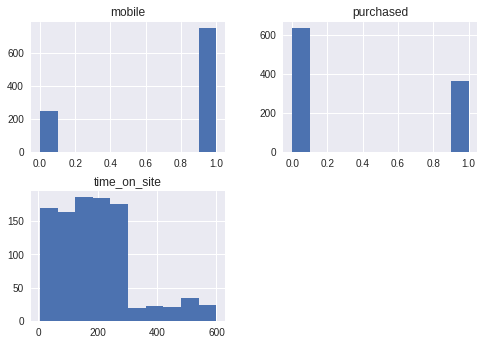

In [53]:
user_data.hist()

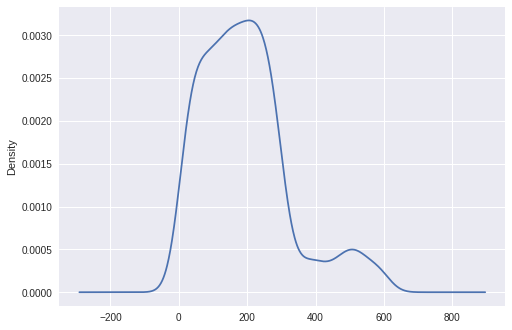

In [54]:
user_data['time_on_site'].plot.density()

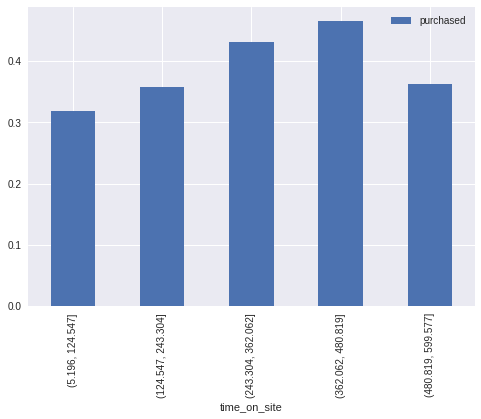

In [57]:
pd.pivot_table(user_data, values='purchased', index=time_bins).plot.bar()

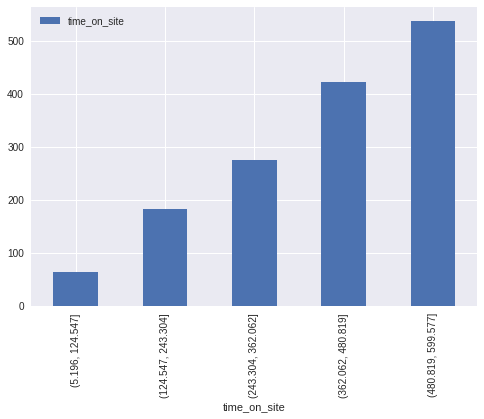

In [58]:
pd.pivot_table(user_data, values='time_on_site', index=time_bins).plot.bar()

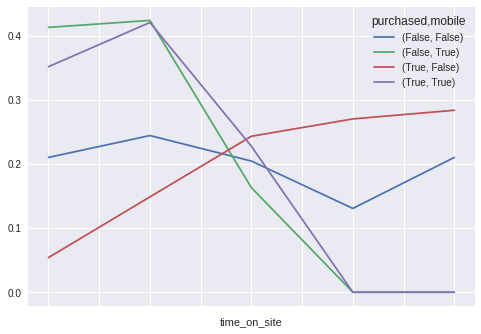

In [68]:
ct = pd.crosstab(time_bins, [user_data['purchased'], user_data['mobile']], normalize='columns')
ct.plot()

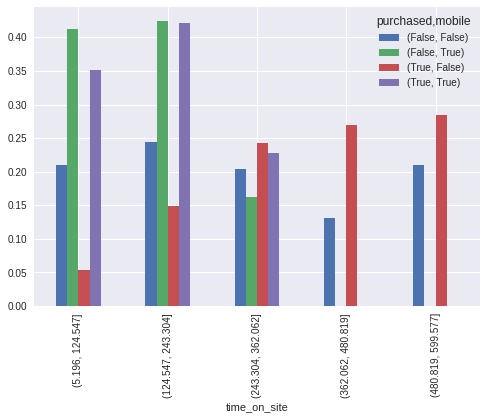

In [69]:
ct.plot(kind='bar')

## Assignment - what's going on here?

Consider the data in `persons.csv` (already prepared for you, in the repo for the week). It has four columns - a unique id, followed by age (in years), weight (in lbs), and exercise time (in minutes/week) of 1200 (hypothetical) people.

Try to figure out which variables are possibly related to each other, and which may be confounding relationships.

In [0]:
# TODO - your code here
# Use what we did live in lecture as an example

# HINT - you can find the raw URL on GitHub and potentially use that
# to load the data with read_csv, or you can upload it yourself

import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

#Retrieve and Load Data
persons_url = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-1-Sprint-1-Dealing-With-Data/master/module4-databackedassertions/persons.csv'
persons_data = pd.read_csv(person_url)

#Drop the unnamed column we can reference the index.
persons_data.drop(persons_data.columns[0], axis=1, inplace=True)


#pd.crosstab(persons_data['exercise_time'], persons_data['age'])

age_bins = pd.cut(persons_data['age'],7)
weight_bins = pd.cut(persons_data['weight'],7)
exer_bins = pd.cut(persons_data['exercise_time'],7)


In [154]:
#Shows the percentage of people and where they fall under given their age and exercise time.
age_exer_ct = pd.crosstab(age_bins, exer_bins, normalize='columns')
age_exer_ct

exercise_time,"(-0.3, 42.857]","(42.857, 85.714]","(85.714, 128.571]","(128.571, 171.429]","(171.429, 214.286]","(214.286, 257.143]","(257.143, 300.0]"
age,,,,,,,
"(17.938, 26.857]",0.086538,0.120,0.148837,0.159236,0.181818,0.171429,0.145985
"(26.857, 35.714]",0.168269,0.135,0.083721,0.165605,0.230769,0.257143,0.197080
"(35.714, 44.571]",0.105769,0.130,0.153488,0.114650,0.118881,0.207143,0.197080
"(44.571, 53.429]",0.096154,0.095,0.083721,0.133758,0.139860,0.121429,0.262774
"(53.429, 62.286]",0.115385,0.120,0.125581,0.121019,0.167832,0.150000,0.197080
"(62.286, 71.143]",0.206731,0.170,0.204651,0.197452,0.160839,0.092857,0.000000
"(71.143, 80.0]",0.221154,0.230,0.200000,0.108280,0.000000,0.000000,0.000000


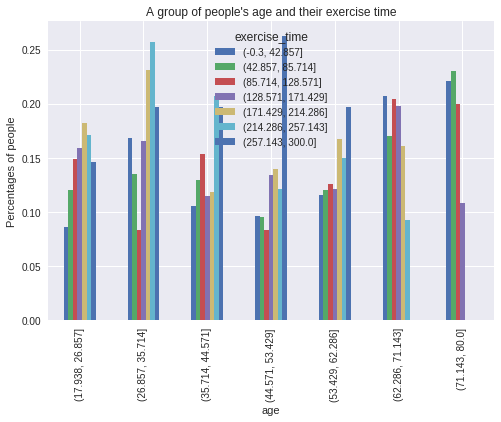

In [158]:
ax = age_exer_ct.plot(kind='bar', title='A group of people\'s age and their exercise time')
ax.set_ylabel('Percentages of people');

In [0]:
?ct.plot

In [136]:
#Shows the percentage of people and where they fall under given their age and weight
pd.crosstab(age_bins, weight_bins, normalize='columns')

weight,"(99.854, 120.857]","(120.857, 141.714]","(141.714, 162.571]","(162.571, 183.429]","(183.429, 204.286]","(204.286, 225.143]","(225.143, 246.0]"
age,,,,,,,
"(17.938, 26.857]",0.158537,0.128114,0.169643,0.145946,0.140845,0.055556,0.12500
"(26.857, 35.714]",0.223577,0.153025,0.169643,0.151351,0.105634,0.211111,0.12500
"(35.714, 44.571]",0.174797,0.170819,0.142857,0.097297,0.140845,0.100000,0.06250
"(44.571, 53.429]",0.126016,0.156584,0.089286,0.151351,0.112676,0.088889,0.12500
"(53.429, 62.286]",0.126016,0.145907,0.151786,0.135135,0.126761,0.177778,0.03125
"(62.286, 71.143]",0.101626,0.156584,0.165179,0.162162,0.211268,0.133333,0.31250
"(71.143, 80.0]",0.089431,0.088968,0.111607,0.156757,0.161972,0.233333,0.21875


In [137]:
#Gives the percentage of people and places them in their respective category of age, weight, and exercise_time
pd.crosstab(age_bins, [weight_bins, exer_bins], normalize='columns')

weight           (99.854, 120.857]                                     \
exercise_time       (-0.3, 42.857] (42.857, 85.714] (85.714, 128.571]   
age                                                                     
(17.938, 26.857]              0.08         0.166667          0.153846   
(26.857, 35.714]              0.12         0.200000          0.076923   
(35.714, 44.571]              0.12         0.133333          0.192308   
(44.571, 53.429]              0.08         0.100000          0.076923   
(53.429, 62.286]              0.20         0.033333          0.115385   
(62.286, 71.143]              0.20         0.200000          0.115385   
(71.143, 80.0]                0.20         0.166667          0.269231   

weight                                                                     \
exercise_time    (128.571, 171.429] (171.429, 214.286] (214.286, 257.143]   
age                                                                         
(17.938, 26.857]           0.179487           0.171429           0.135135   
(26.857, 35.714]           0.205128           0.314286           0.297297   
(35.714, 44.571]           0.205128           0.142857           0.243243   
(44.571, 53.429]           0.051282           0.114286           0.108108   
(53.429, 62.286]           0.128205           0.114286           0.162162   
(62.286, 71.143]           0.102564           0.142857           0.054054   
(71.143, 80.0]             0.128205           0.000000           0.000000   

weight                            (120.857, 141.714]                   \
exercise_time    (257.143, 300.0]     (-0.3, 42.857] (42.857, 85.714]   
age                                                                     
(17.938, 26.857]         0.185185           0.181818          0.09375   
(26.857, 35.714]         0.259259           0.045455          0.12500   
(35.714, 44.571]         0.166667           0.045455          0.18750   
(44.571, 53.429]         0.259259           0.045455          0.15625   
(53.429, 62.286]         0.129630           0.136364          0.09375   
(62.286, 71.143]         0.000000           0.318182          0.15625   
(71.143, 80.0]           0.000000           0.227273          0.18750   

weight                                                                    \
exercise_time    (85.714, 128.571] (128.571, 171.429] (171.429, 214.286]   
age                                                                        
(17.938, 26.857]             0.150           0.111111              0.100   
(26.857, 35.714]             0.050           0.166667              0.175   
(35.714, 44.571]             0.150           0.138889              0.150   
(44.571, 53.429]             0.075           0.111111              0.125   
(53.429, 62.286]             0.050           0.194444              0.225   
(62.286, 71.143]             0.250           0.194444              0.225   
(71.143, 80.0]               0.275           0.083333              0.000   

weight                                               (141.714, 162.571]  \
exercise_time    (214.286, 257.143] (257.143, 300.0]     (-0.3, 42.857]   
age                                                                       
(17.938, 26.857]           0.129630         0.140351           0.034483   
(26.857, 35.714]           0.259259         0.157895           0.310345   
(35.714, 44.571]           0.222222         0.210526           0.172414   
(44.571, 53.429]           0.185185         0.280702           0.034483   
(53.429, 62.286]           0.092593         0.210526           0.103448   
(62.286, 71.143]           0.111111         0.000000           0.103448   
(71.143, 80.0]             0.000000         0.000000           0.241379   

weight                                                                  \
exercise_time    (42.857, 85.714] (85.714, 128.571] (128.571, 171.429]   
age                                                                      
(17.938, 26.857]         0.090909

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f2d685ba518>,
      dtype=object)

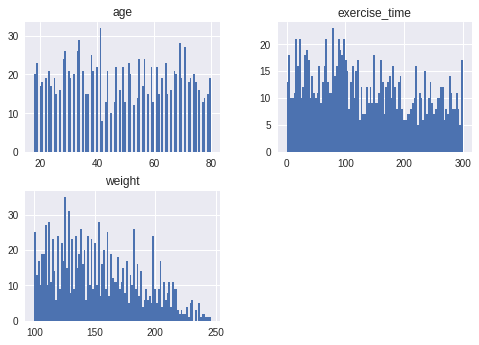

In [135]:
persons_data.hist(bins=100)
#Age - Number of people's age
#Exercise_time - Number of people's exercise slightly increase from 0 to 100 and decreases starting at 100
#Weight - Number of people of people's weight increases from 100 to 125 and decrreases starting at 125

### Assignment questions

After you've worked on some code, answer the following questions in this text block:

1.  What are the variable types in the data?
2.  What are the relationships between the variables?
3.  Which relationships are "real", and which spurious?


## Stretch goals and resources

Following are *optional* things for you to take a look at. Focus on the above assignment first, and make sure to commit and push your changes to GitHub.

- [Spurious Correlations](http://tylervigen.com/spurious-correlations)
- [NIH on controlling for confounding variables](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4017459/)

Stretch goals:

- Produce your own plot inspired by the Spurious Correlation visualizations (and consider writing a blog post about it - both the content and how you made it)
- Pick one of the techniques that NIH highlights for confounding variables - we'll be going into many of them later, but see if you can find which Python modules may help (hint - check scikit-learn)